In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.api.types import CategoricalDtype
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

### Data preparation

In [2]:
data = pd.read_csv("data/train_users_processed.csv")
test_data = pd.read_csv("data/test_users.csv")

In [3]:
def clear_test_data(main_data):
    # set appropriate data types
    int_time_to_str = lambda x: x[:4] + '-' + x[4:6] + '-' + x[6:8] + ' ' + x[8:10] + ':' + x[10:12] + ':' + x[12:]

    main_data["date_account_created"] = main_data["date_account_created"].astype("datetime64[ns]")
    main_data["timestamp_first_active"] = main_data["timestamp_first_active"].astype(str) \
                                                                             .apply(int_time_to_str) \
                                                                             .astype("datetime64[ns]")
    main_data["date_first_booking"] = main_data["date_first_booking"].astype("datetime64[ns]")
    main_data["signup_flow"] = main_data["signup_flow"].astype(str)
    
    # Dealing with NaN values and clearing dataset
    
    main_data = main_data[(main_data["age"] < 100) | (main_data["age"].isnull())]
    main_data = main_data.dropna(subset=["first_affiliate_tracked"])
    main_data = main_data.drop("date_first_booking", axis=1)
    
    ages = main_data.groupby(["gender"]).mean().reset_index()
    ages = ages.rename(columns={"age": "mean_age"})
    ages["mean_age"] = ages["mean_age"].round()
    main_data = main_data.merge(ages, on=["gender"])
    main_data["age"] = main_data["age"].fillna(main_data["mean_age"])
    main_data = main_data.drop("mean_age", axis=1)
    
    return main_data

def encode_data(data):
    df = data.drop(["id", 
                "date_account_created", 
                "affiliate_channel", 
                "timestamp_first_active", 
                "first_browser",
                "language"], axis=1)

    df = pd.get_dummies(df, columns=["gender", 
                                     "signup_method", 
                                     "signup_flow", 
                                     "affiliate_provider", 
                                     "first_affiliate_tracked", 
                                     "signup_app", 
                                     "first_device_type"])
    
    return df

In [4]:
df = encode_data(data)

test_data = clear_test_data(test_data)
test_df = encode_data(test_data)

cat_type = CategoricalDtype(df["country_destination"].unique(), ordered=True)
df["country_destination"] = df["country_destination"].astype(cat_type).cat.codes

X = df.drop(["country_destination"], axis=1)
Y = df["country_destination"]

cols_not_in_test = set(X).difference(set(test_df.columns))
cols_not_in_X = set(test_df).difference(set(X.columns))

for col in cols_not_in_test:
    test_df[col] = 0
    
for col in cols_not_in_X:
    X[col] = 0
    
test_df.columns = X.columns

### Train model

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

tree = DecisionTreeClassifier(max_depth=8)

tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=8)

In [6]:
y_pred = tree.predict(X_test)

In [7]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average="macro")
recall = recall_score(y_test, y_pred, average="macro")

/home/uladzimir/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [8]:
print(f"Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}")

Accuracy: 0.6464779460171165
Precision: 0.2385965934196305
Recall: 0.16027613672981836


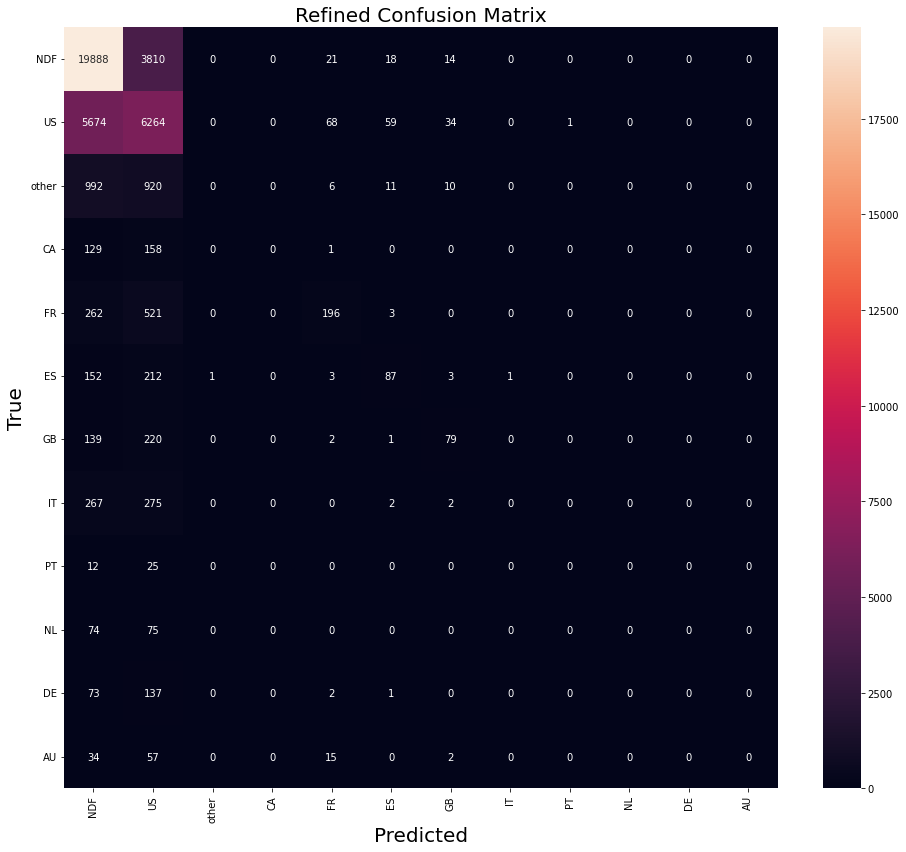

In [9]:
cm = confusion_matrix(y_test, y_pred)

class_names = ['NDF', 'US', 'other', 'CA', 'FR', 'ES', 'GB', 'IT', 'PT', 'NL', 'DE', 'AU']

# Plot confusion matrix in a beautiful manner
fig = plt.figure(figsize=(16, 14))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g'); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted', fontsize=20)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=90)
ax.xaxis.set_ticklabels(class_names, fontsize = 10)
ax.xaxis.tick_bottom()

ax.set_ylabel('True', fontsize=20)
ax.yaxis.set_ticklabels(class_names, fontsize = 10)
plt.yticks(rotation=0)

plt.title('Refined Confusion Matrix', fontsize=20)

plt.show()

### Run model on test data

In [23]:
y_test_pred = tree.predict(test_df)
y_test_pred = pd.Series(y_test_pred)
categories = cat_type.categories

y_test_pred = y_test_pred.apply(lambda x: categories[x])

In [24]:
submission = pd.DataFrame({"id": test_data["id"], "country": y_test_pred})

In [29]:
submission.to_csv("submissions/submission_0.csv")